avrora, fop, jython, luindex,
lusearch, lusearch-fix, pmd and xalan

https://bergel.eu/MyPapers/Cana21a-JVMGlagsAndGA.pdf

In [16]:
! export WANDB_NOTEBOOK_NAME="main.ipynb"
import wandb

PROJECT_NAME = "Reinforcement Learning (DQN) - JVM-GC"
WANDB_KEY = "4b077df3688052b0f43705d6b4d712c05fb979b7"
config = dict(
    competition = PROJECT_NAME,
    _wandb_kernel = 'lemon',
    seed = 42,
)

In [17]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename="gc-ml-ppo.log",
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s')


logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.INFO)
# logger.error("test")

In [18]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tf_agents.agents import PPOAgent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec, from_spec
from tf_agents import trajectories
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

# from env.PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from env.PyEnvironments import JVMEnv
from env.PyEnvironmentsTest import JVMEnv # !!!
from util.plots_util import plot_dataset, plot_goal_heatmap


In [19]:
# TEST_JDK_PATH = "/Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk"
# BM = "avrora"
# BM_TEST = "kafka"
# BM_PATH = "/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar"
# CALLBACK_PATH = "/home/vsakovskaya/gc-ml/dacapo/DacapoCallback/DacapoChopin/VMStatCallback.java"
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')

env_args = {
    "jdk_path": "jdk-11.0.20.1.jdk",
    "bm_path": "dacapo-bench.jar",
    "gc_viewer_jar": "gcviewer-1.36.jar",
    "callback_path": "callback/VMStatCallback.java",
    "n": 5,
    "goal": "avgGCPause",
    "verbose": False,
}

def get_tf_env(name, args):
    env = JVMEnv(bm_name=name, **args)
    tf_env = tf_py_environment.TFPyEnvironment(env, isolation=True) 
    return tf_env

# env_train_1 = JVMEnv(bm_name="avrora", **env_args)
# env_train_2 = JVMEnv(bm_name="kafka", **env_args)

train_env = get_tf_env(name="avrora", args=env_args)

action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,



In [20]:
def get_q_net(action_spec, fc_layer_params = (100, 75, 50)):
    action_tensor_spec = tensor_spec.from_spec(action_spec)
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def dense_layer(num_units):
        """
        Define a helper function to create Dense layers configured 
        with the right activation and kernel initializer.
        """
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    # QNetwork consists of a sequence of Dense layers followed by a dense layer
    # with `num_actions` units to generate one q_value per available action as
    # its output.
    dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2))
    q_net = sequential.Sequential(dense_layers + [q_values_layer])
    return q_net

def collect_step(environment, policy, replay_buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)

    next_time_step = environment.step(action_step.action)
    # reward = next_time_step.reward
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    return traj

def save_dataset(data, path):
    step_counter = tf.Variable(0, trainable=False)
    checkpoint_prefix = "checkpoint"
    checkpoint_args = {
        "checkpoint_interval": 50,
        "step_counter": step_counter,
        "directory": checkpoint_prefix,
        "max_to_keep": 3,
    }
    try:
        data.save(path, checkpoint_args=checkpoint_args)
    except:
        pass

def save_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).save(path)

def restore_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).restore(path)

def get_dataset(replay_buffer, size, batch_size, collect_data_spec, n_step_update, create: bool = True, save: bool = False):
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=collect_data_spec, # agent.collect_data_spec
        batch_size=1, # train_env.batch_size
        max_length=size) # capacity

    if create:
        for _ in tqdm(range(size)):
            traj = collect_step(train_env, random_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        if save: save_rb(replay_buffer, dataset_path)
    else: 
        restore_rb(replay_buffer, dataset_path+'-1')

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size,
        num_steps=n_step_update + 1, 
        single_deterministic_pass=False).prefetch(3)
    # iterator = iter(dataset)
    return dataset
    
def compute_avg_return(environment, policy, num_episodes=50):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for non-episodic tasks.
    """
    total_return = 0.0
    time_step = environment.reset()
    for _ in tqdm(range(num_episodes)):
        action_step = policy.action(time_step, seed=42)
        time_step = environment.step(action_step.action)
        total_return += time_step.reward

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def compute_avg_return_episodic(environment, policy, num_episodes=10, patience=100):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for episodic tasks.
    """
    total_return = 0.0
    for _ in tqdm(range(num_episodes)):

        time_step = environment.reset()
        episode_return = 0.0
        i = 0

        while not time_step.is_last():
            if i >= patience:
                break
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            # print("time step:", action_step)
            # print("action:", action_step.action)
            obs = time_step.observation.numpy()[0]
            rwd = time_step.reward.numpy()[0]
            # logger.debug(f"[COMPUTE AVERAGE RETURN EPISODIC] action: {action_step.action}, obs: {obs}, reward: {rwd}")
            episode_return += time_step.reward
            i += 1
        total_return += episode_return / i

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def create_networks(observation_spec, action_spec, fc_layer_params):
    actor_net = ActorDistributionNetwork(
            observation_spec, # input
            action_spec, # output
            fc_layer_params=fc_layer_params,
            activation_fn=tf.keras.activations.tanh)
    
    value_net = ValueNetwork(
            observation_spec, # input
            fc_layer_params=fc_layer_params,
            activation_fn=tf.keras.activations.tanh)

    return actor_net, value_net

def plot_training(loss, rewards, num_steps, eval_interval):
    fig, ax1 = plt.subplots()

    steps = [step for step in range(0, num_steps, eval_interval)]
    color = 'tab:red'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(steps, loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('rewards', color=color)  # we already handled the x-label with ax1
    ax2.plot(steps, rewards[:200], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [21]:
def get_dataset_iter(envs, size, _agent):
    from random import randrange
    assert len(envs) >= 1, "Environment list is empty!"
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=_agent.collect_data_spec, # agent.collect_data_spec
        batch_size=envs[0].batch_size, # train_env.batch_size
        max_length=size) # capacity

    for _ in tqdm(range(size)):
        indx = randrange(len(envs))
        traj = collect_step(envs[indx], _agent.collect_policy, replay_buffer)
        replay_buffer.add_batch(traj)
            
    dataset = replay_buffer.as_dataset(
        sample_batch_size=batch_size,
        num_steps=train_episodes_per_iteration+1,
        num_parallel_calls=train_episodes_per_iteration).prefetch(train_episodes_per_iteration)
    dataset_iter = iter(dataset)
    return dataset_iter

In [22]:
collect_steps_per_iteration = 1
dataset_size = 10000
# fc_layer_params = (100, 75, 50)
# fc_layer_params = (200, 100)
# fc_layer_params = (128, 128, 128)
fc_layer_params = (200, 150, 100, 75, 50)

batch_size = 24
learning_rate = 1e-3
# learning_rate = 0.0005

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

# train_episodes_per_iteration = 10
train_episodes_per_iteration = 5
n_step_update = 4
actor_net, value_net = create_networks(observation_spec, action_spec, fc_layer_params)
global_step = tf.compat.v1.train.get_or_create_global_step()

agent_args = {
    "optimizer": tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    "actor_net": actor_net,
    "value_net": value_net,
    "train_step_counter": global_step,
    # "train_step_counter": global_step,
    # "importance_ratio_clipping": 0.1,
    # "num_epochs": 20,
}

In [23]:
agent = PPOAgent(
  time_step_spec,
  action_spec,
  **agent_args
)

agent.initialize()
agent.train = common.function(agent.train, autograph=False)

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = time_step_spec,
  action_spec = action_spec,
  automatic_state_reset=True,
  clip=False,
  emit_log_probability=True
)

def get_rb_and_cd(_env, _agent):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=_agent.collect_data_spec, # agent.collect_data_spec
      batch_size=_env.batch_size, # train_env.batch_size
      max_length=dataset_size) # capacity

  replay_buffer_observer = replay_buffer.add_batch

  collect_driver = DynamicEpisodeDriver(
      _env,
      _agent.collect_policy,
      observers=[replay_buffer_observer], # + train_metrics,
      num_episodes=train_episodes_per_iteration)
  
  return replay_buffer, collect_driver


In [24]:
policy_dir = os.path.join(tempdir, '0_policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

## Agent Training

In [26]:
def train(_agent, _env_train, _env_val, replay_buffer, collect_driver,
          steps: int = 5000, 
          use_wandb: bool = False,
          eval_interval: int=100):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    
    _env_train.reset()
    _env_val.reset()
    _agent.train_step_counter.assign(0)

    time_step = None
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []
    rewards = []
    for step in tqdm(range(steps)):
        
        time_step, policy_state = collect_driver.run(
            time_step=time_step,
            policy_state=policy_state,
            maximum_iterations=200,
        )

        experience = replay_buffer.gather_all()
        train_loss = _agent.train(experience)
        replay_buffer.clear()
        
        if step % eval_interval == 0:
            avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=20)

            loss.append(train_loss.loss.numpy())
            # observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    return loss, observations, rewards

def _train(_agent, _env_train, _env_val, data_iterator,
          steps: int = 5000, 
          use_wandb: bool = False,
          eval_interval: int=100):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    
    _env_train.reset()
    _env_val.reset()
    _agent.train_step_counter.assign(0)

    time_step = None
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []
    rewards = []
    for step in tqdm(range(steps)):
        
        experience, _ = next(data_iterator)
        train_loss = _agent.train(experience)
        
        if step % eval_interval == 0:
            avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=20)

            loss.append(train_loss.loss.numpy())
            # observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    
    return loss, observations, rewards

### Train Sequentially

In [27]:
num_steps = 3000

train_env_copy = get_tf_env("avrora", env_args)

train_env_2 = get_tf_env("kafka", env_args)
train_env_2_copy = get_tf_env("kafka", env_args)

test_env = get_tf_env("test", env_args)
test_env_copy = get_tf_env("test", env_args)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {

In [28]:
# Train on first
collect_driver, replay_buffer = get_rb_and_cd(train_env, agent)
loss, observations, rewards = train(
    agent, train_env, train_env_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))

  0%|          | 1/3000 [00:27<22:33:51, 27.09s/it]

step = 0: loss = 102.6141586303711, reward = 0.28046756982803345


  3%|▎         | 102/3000 [01:00<09:26,  5.11it/s]

step = 100: loss = -0.40335899591445923, reward = 1.280665636062622


  7%|▋         | 202/3000 [01:14<09:02,  5.16it/s]

step = 200: loss = -0.40187013149261475, reward = 1.2897497415542603


 10%|█         | 302/3000 [01:29<09:07,  4.93it/s]

step = 300: loss = 0.4024907648563385, reward = 1.2897497415542603


 13%|█▎        | 402/3000 [01:44<12:36,  3.44it/s]

step = 400: loss = -0.4009440243244171, reward = 1.2897497415542603


 17%|█▋        | 502/3000 [02:00<08:04,  5.15it/s]

step = 500: loss = -0.40200239419937134, reward = 1.2897497415542603


 20%|██        | 602/3000 [02:15<08:30,  4.70it/s]

step = 600: loss = -0.4066748321056366, reward = 1.2897497415542603


 23%|██▎       | 702/3000 [02:29<07:22,  5.20it/s]

step = 700: loss = -0.40431803464889526, reward = 1.2897497415542603


 27%|██▋       | 802/3000 [02:45<13:03,  2.80it/s]

step = 800: loss = -0.40389442443847656, reward = 1.2480151653289795


 30%|███       | 902/3000 [03:00<06:44,  5.18it/s]

step = 900: loss = -0.5171404480934143, reward = 1.2897497415542603


 33%|███▎      | 1002/3000 [03:14<06:29,  5.13it/s]

step = 1000: loss = -0.40201324224472046, reward = 1.2897497415542603


 37%|███▋      | 1102/3000 [03:29<06:10,  5.13it/s]

step = 1100: loss = -0.4019290506839752, reward = 1.2897497415542603


 40%|████      | 1202/3000 [03:44<05:48,  5.16it/s]

step = 1200: loss = -0.40204358100891113, reward = 1.2897497415542603


 43%|████▎     | 1302/3000 [03:59<05:38,  5.02it/s]

step = 1300: loss = -0.4021153450012207, reward = 1.2897497415542603


 47%|████▋     | 1401/3000 [04:14<05:51,  4.55it/s]

step = 1400: loss = -0.40204861760139465, reward = 1.2897497415542603


 50%|█████     | 1502/3000 [04:29<04:56,  5.05it/s]

step = 1500: loss = -0.40198034048080444, reward = 1.2897497415542603


 53%|█████▎    | 1602/3000 [04:44<04:30,  5.17it/s]

step = 1600: loss = -0.40258926153182983, reward = 1.2897497415542603


 57%|█████▋    | 1702/3000 [04:59<04:11,  5.16it/s]

step = 1700: loss = -0.402495801448822, reward = 1.2897497415542603


 60%|██████    | 1802/3000 [05:14<03:51,  5.18it/s]

step = 1800: loss = -0.4020422101020813, reward = 1.2897497415542603


 63%|██████▎   | 1902/3000 [05:29<04:13,  4.34it/s]

step = 1900: loss = -0.4019875228404999, reward = 1.2897497415542603


 67%|██████▋   | 2002/3000 [05:44<03:15,  5.11it/s]

step = 2000: loss = -0.4020099639892578, reward = 1.2897497415542603


 70%|███████   | 2102/3000 [06:00<02:53,  5.16it/s]

step = 2100: loss = -0.40153512358665466, reward = 1.2897497415542603


 73%|███████▎  | 2202/3000 [06:15<02:49,  4.71it/s]

step = 2200: loss = -0.400035560131073, reward = 1.2897497415542603


 77%|███████▋  | 2302/3000 [06:30<02:15,  5.15it/s]

step = 2300: loss = -0.4024899899959564, reward = 1.2897497415542603


 80%|████████  | 2402/3000 [06:44<02:04,  4.79it/s]

step = 2400: loss = -0.40124115347862244, reward = 1.2897497415542603


 83%|████████▎ | 2502/3000 [06:59<01:49,  4.56it/s]

step = 2500: loss = -0.40203845500946045, reward = 1.2897497415542603


 87%|████████▋ | 2602/3000 [07:13<01:18,  5.08it/s]

step = 2600: loss = -0.40201422572135925, reward = 1.2897497415542603


 90%|█████████ | 2702/3000 [07:28<00:57,  5.15it/s]

step = 2700: loss = -0.40200597047805786, reward = 1.2897497415542603


 93%|█████████▎| 2802/3000 [07:43<00:38,  5.12it/s]

step = 2800: loss = -0.4020169675350189, reward = 1.2897497415542603


 97%|█████████▋| 2902/3000 [07:57<00:20,  4.88it/s]

step = 2900: loss = -0.40141090750694275, reward = 1.2897497415542603


100%|██████████| 50/50 [00:30<00:00,  1.65it/s]

AVG RETURN - KAFKA: -1.0951742


In [29]:
# Train on second
collect_driver, replay_buffer = get_rb_and_cd(train_env_2, agent)
loss, observations, rewards = train(
    agent, train_env_2, train_env_2_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))


  0%|          | 1/3000 [00:12<10:45:41, 12.92s/it]

step = 0: loss = 0.23992592096328735, reward = -1.094357967376709


  3%|▎         | 101/3000 [02:48<4:07:08,  5.12s/it]

step = 100: loss = -0.04756331071257591, reward = -1.095718264579773


  7%|▋         | 201/3000 [05:32<4:20:18,  5.58s/it]

step = 200: loss = 0.01569918729364872, reward = -1.095718264579773


 10%|█         | 301/3000 [08:14<3:35:36,  4.79s/it]

step = 300: loss = 0.027913261204957962, reward = -1.095718264579773


 13%|█▎        | 401/3000 [10:51<3:28:08,  4.81s/it]

step = 400: loss = 0.026388660073280334, reward = -1.095718264579773


 17%|█▋        | 501/3000 [13:29<3:30:47,  5.06s/it]

step = 500: loss = 0.050847191363573074, reward = -1.095718264579773


 20%|██        | 601/3000 [16:08<3:19:06,  4.98s/it]

step = 600: loss = 0.05089189484715462, reward = -1.095718264579773


 23%|██▎       | 701/3000 [18:43<3:06:54,  4.88s/it]

step = 700: loss = 0.05062983185052872, reward = -1.095718264579773


 27%|██▋       | 801/3000 [21:22<3:01:49,  4.96s/it]

step = 800: loss = 0.05028387904167175, reward = -1.095718264579773


 30%|███       | 901/3000 [23:59<2:47:50,  4.80s/it]

step = 900: loss = 0.04961911588907242, reward = -1.095718264579773


 33%|███▎      | 1001/3000 [26:36<2:39:13,  4.78s/it]

step = 1000: loss = 0.04881724342703819, reward = -1.095718264579773


 37%|███▋      | 1101/3000 [29:08<2:30:42,  4.76s/it]

step = 1100: loss = 0.04760364443063736, reward = -1.095718264579773


 40%|████      | 1201/3000 [31:42<2:22:38,  4.76s/it]

step = 1200: loss = 0.04574316367506981, reward = -1.095718264579773


 43%|████▎     | 1301/3000 [34:14<2:21:03,  4.98s/it]

step = 1300: loss = 0.04151776432991028, reward = -1.095718264579773


 47%|████▋     | 1401/3000 [36:47<2:07:11,  4.77s/it]

step = 1400: loss = 0.0467989556491375, reward = -1.095718264579773


 50%|█████     | 1501/3000 [39:21<2:02:05,  4.89s/it]

step = 1500: loss = 0.047061603516340256, reward = -1.095718264579773


 53%|█████▎    | 1601/3000 [41:54<1:51:30,  4.78s/it]

step = 1600: loss = 0.04712197184562683, reward = -1.095718264579773


 57%|█████▋    | 1701/3000 [44:27<1:43:34,  4.78s/it]

step = 1700: loss = 0.04722379893064499, reward = -1.095718264579773


 60%|██████    | 1801/3000 [47:01<1:42:02,  5.11s/it]

step = 1800: loss = 0.046851687133312225, reward = -1.095718264579773


 63%|██████▎   | 1901/3000 [49:56<1:30:36,  4.95s/it]

step = 1900: loss = 0.04698016494512558, reward = -1.095718264579773


 67%|██████▋   | 2001/3000 [52:29<1:18:55,  4.74s/it]

step = 2000: loss = 0.046965342015028, reward = -1.095718264579773


 70%|███████   | 2101/3000 [55:04<1:11:31,  4.77s/it]

step = 2100: loss = 0.04709947854280472, reward = -1.095718264579773


 73%|███████▎  | 2201/3000 [57:36<1:03:22,  4.76s/it]

step = 2200: loss = 0.034701552242040634, reward = -1.095718264579773


 77%|███████▋  | 2301/3000 [1:00:13<57:22,  4.93s/it]

step = 2300: loss = 0.0582413375377655, reward = -1.095718264579773


 80%|████████  | 2401/3000 [1:02:56<49:52,  5.00s/it]

step = 2400: loss = 0.0011234291596338153, reward = -1.095718264579773


 83%|████████▎ | 2501/3000 [1:41:12<43:19,  5.21s/it]

step = 2500: loss = 0.059934187680482864, reward = -1.095718264579773


 87%|████████▋ | 2601/3000 [1:45:04<33:39,  5.06s/it]

step = 2600: loss = -0.014887774363160133, reward = -1.095718264579773


 90%|█████████ | 2701/3000 [1:47:42<23:39,  4.75s/it]

step = 2700: loss = 0.013810863718390465, reward = -0.7224888801574707


 93%|█████████▎| 2801/3000 [1:50:18<16:30,  4.98s/it]

step = 2800: loss = 0.017519423738121986, reward = -0.7224825620651245


 97%|█████████▋| 2901/3000 [1:52:50<07:49,  4.74s/it]

step = 2900: loss = 0.020173329859972, reward = -0.7224825620651245


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]

AVG RETURN - KAFKA: -0.72248244


In [30]:

print("AVG RETURN - TEST:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))

# Test environment
collect_driver, replay_buffer = get_rb_and_cd(test_env, agent)
loss, observations, rewards = train(
    agent, test_env, test_env_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - TEST:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))

100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


AVG RETURN - TEST: -0.09791789


  0%|          | 1/3000 [00:13<11:13:44, 13.48s/it]

step = 0: loss = -0.04970337077975273, reward = -0.06765811145305634


  3%|▎         | 101/3000 [02:58<3:59:28,  4.96s/it]

step = 100: loss = -0.002319173188880086, reward = -0.11809100955724716


  7%|▋         | 201/3000 [05:34<3:49:03,  4.91s/it]

step = 200: loss = -0.001999561209231615, reward = -0.11809100955724716


 10%|█         | 301/3000 [07:57<2:55:25,  3.90s/it]

step = 300: loss = 0.637097179889679, reward = -0.11809100955724716


 13%|█▎        | 401/3000 [08:48<2:53:10,  4.00s/it]

step = 400: loss = 0.3378632962703705, reward = 0.1518501341342926


 17%|█▋        | 501/3000 [09:44<2:40:10,  3.85s/it]

step = 500: loss = 0.29114043712615967, reward = 0.1518501341342926


 20%|██        | 601/3000 [10:46<2:37:43,  3.94s/it]

step = 600: loss = 0.27805569767951965, reward = 0.1518501341342926


 23%|██▎       | 701/3000 [11:45<2:25:07,  3.79s/it]

step = 700: loss = 0.2481951117515564, reward = 0.1518501341342926


 27%|██▋       | 801/3000 [12:51<2:23:01,  3.90s/it]

step = 800: loss = 0.26682373881340027, reward = 0.1518501341342926


 30%|███       | 901/3000 [13:55<2:25:32,  4.16s/it]

step = 900: loss = 0.2887151837348938, reward = 0.1518501341342926


 33%|███▎      | 1001/3000 [15:00<2:04:19,  3.73s/it]

step = 1000: loss = 0.24205642938613892, reward = 0.1518501341342926


 37%|███▋      | 1101/3000 [16:01<2:01:58,  3.85s/it]

step = 1100: loss = 0.23392656445503235, reward = 0.1518501341342926


 40%|████      | 1201/3000 [17:02<1:54:06,  3.81s/it]

step = 1200: loss = 0.20439070463180542, reward = 0.1518501341342926


 43%|████▎     | 1301/3000 [18:01<1:53:04,  3.99s/it]

step = 1300: loss = 0.2279774695634842, reward = 0.1518501341342926


 47%|████▋     | 1401/3000 [19:05<1:41:22,  3.80s/it]

step = 1400: loss = 0.2342691570520401, reward = 0.1518501341342926


 50%|█████     | 1501/3000 [20:05<1:33:27,  3.74s/it]

step = 1500: loss = 0.23698203265666962, reward = 0.1518501341342926


 53%|█████▎    | 1601/3000 [21:05<1:29:33,  3.84s/it]

step = 1600: loss = 0.21993388235569, reward = 0.1518501341342926


 57%|█████▋    | 1701/3000 [22:06<1:26:33,  4.00s/it]

step = 1700: loss = 0.239291712641716, reward = 0.1518501341342926


 60%|██████    | 1801/3000 [23:04<1:15:58,  3.80s/it]

step = 1800: loss = 0.19207340478897095, reward = 0.1518501341342926


 63%|██████▎   | 1901/3000 [24:04<1:09:45,  3.81s/it]

step = 1900: loss = 0.19634351134300232, reward = 0.1518501341342926


 67%|██████▋   | 2001/3000 [25:05<1:06:28,  3.99s/it]

step = 2000: loss = 0.18686339259147644, reward = 0.1518501341342926


 70%|███████   | 2101/3000 [26:08<57:38,  3.85s/it]

step = 2100: loss = 0.20166490972042084, reward = 0.1518501341342926


 73%|███████▎  | 2201/3000 [27:07<51:20,  3.86s/it]

step = 2200: loss = 0.18926644325256348, reward = 0.1518501341342926


 77%|███████▋  | 2301/3000 [28:06<44:31,  3.82s/it]

step = 2300: loss = 0.20836588740348816, reward = 0.1518501341342926


 80%|████████  | 2401/3000 [29:06<38:39,  3.87s/it]

step = 2400: loss = 0.13284115493297577, reward = 0.1518501341342926


 83%|████████▎ | 2501/3000 [30:08<33:17,  4.00s/it]

step = 2500: loss = 0.16821995377540588, reward = 0.1518501341342926


 87%|████████▋ | 2601/3000 [31:07<27:03,  4.07s/it]

step = 2600: loss = 0.14804477989673615, reward = 0.1518501341342926


 90%|█████████ | 2701/3000 [32:06<18:35,  3.73s/it]

step = 2700: loss = 0.10050634294748306, reward = 0.1518501341342926


 93%|█████████▎| 2801/3000 [33:07<12:46,  3.85s/it]

step = 2800: loss = 0.07741110026836395, reward = 0.1518501341342926


 97%|█████████▋| 2901/3000 [34:07<06:22,  3.87s/it]

step = 2900: loss = 0.2126760482788086, reward = 0.1518501341342926


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

AVG RETURN - TEST: 0.15185018


Final results.

In [31]:
print("AVG RETURN - AVRORA:", 
      compute_avg_return_episodic(train_env, agent.policy, num_episodes=50))

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))

print("AVG RETURN - TEST:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))

100%|██████████| 50/50 [00:00<00:00, 74.34it/s]


AVG RETURN - AVRORA: 1.2897495


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


AVG RETURN - KAFKA: -0.6872998


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

AVG RETURN - TEST: 0.15185018


In [32]:
# Continue to train on second
collect_driver, replay_buffer = get_rb_and_cd(train_env_2, agent)
loss, observations, rewards = train(
    agent, train_env_2, train_env_2_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))


  0%|          | 1/3000 [00:12<10:40:12, 12.81s/it]

step = 0: loss = 1.0708450078964233, reward = -0.6872997283935547


  3%|▎         | 101/3000 [02:49<4:07:36,  5.12s/it]

step = 100: loss = 0.01032012328505516, reward = -0.7224825620651245


  7%|▋         | 201/3000 [05:24<3:54:44,  5.03s/it]

step = 200: loss = 0.008337455801665783, reward = -0.7224825620651245


 10%|█         | 301/3000 [08:04<3:49:26,  5.10s/it]

step = 300: loss = 0.015153888612985611, reward = -0.7224825620651245


 13%|█▎        | 401/3000 [10:41<3:25:02,  4.73s/it]

step = 400: loss = 0.04072941467165947, reward = -0.7224825620651245


 17%|█▋        | 501/3000 [13:13<3:16:34,  4.72s/it]

step = 500: loss = 0.025839729234576225, reward = -0.7224825620651245


 20%|██        | 601/3000 [15:49<3:18:07,  4.96s/it]

step = 600: loss = 0.04873916134238243, reward = -0.7224825620651245


 23%|██▎       | 701/3000 [18:24<3:02:58,  4.78s/it]

step = 700: loss = 0.0132971853017807, reward = -0.7224825620651245


 27%|██▋       | 801/3000 [21:03<2:57:36,  4.85s/it]

step = 800: loss = 0.025136852636933327, reward = -0.7224825620651245


 30%|███       | 901/3000 [23:40<2:49:57,  4.86s/it]

step = 900: loss = 0.04865988716483116, reward = -0.7224825620651245


 33%|███▎      | 1001/3000 [26:15<2:41:14,  4.84s/it]

step = 1000: loss = -0.060474611818790436, reward = -0.1822998821735382


 37%|███▋      | 1101/3000 [28:50<2:38:56,  5.02s/it]

step = 1100: loss = 0.001056360430084169, reward = -0.1822998821735382


 40%|████      | 1201/3000 [31:31<2:26:28,  4.89s/it]

step = 1200: loss = 0.0018581876065582037, reward = -0.1822998821735382


 43%|████▎     | 1301/3000 [34:09<2:17:57,  4.87s/it]

step = 1300: loss = -0.0023872079327702522, reward = -0.1822998821735382


 47%|████▋     | 1401/3000 [36:44<2:10:01,  4.88s/it]

step = 1400: loss = 0.01805002987384796, reward = -0.1822998821735382


 50%|█████     | 1501/3000 [39:19<1:58:40,  4.75s/it]

step = 1500: loss = -0.055307794362306595, reward = -0.1822998821735382


 53%|█████▎    | 1601/3000 [41:51<1:50:34,  4.74s/it]

step = 1600: loss = 0.0010385647183284163, reward = -0.1822998821735382


 57%|█████▋    | 1701/3000 [44:23<1:44:25,  4.82s/it]

step = 1700: loss = -0.05765068158507347, reward = -0.1822998821735382


 60%|██████    | 1801/3000 [46:57<1:36:52,  4.85s/it]

step = 1800: loss = 0.0410073883831501, reward = -0.1822998821735382


 63%|██████▎   | 1901/3000 [49:31<1:27:47,  4.79s/it]

step = 1900: loss = -0.022543426603078842, reward = -0.1822998821735382


 67%|██████▋   | 2001/3000 [52:04<1:20:01,  4.81s/it]

step = 2000: loss = -0.03834795951843262, reward = -0.1822998821735382


 70%|███████   | 2101/3000 [54:39<1:12:04,  4.81s/it]

step = 2100: loss = 0.038611143827438354, reward = -0.1822998821735382


 73%|███████▎  | 2201/3000 [57:13<1:04:08,  4.82s/it]

step = 2200: loss = 0.015484925359487534, reward = -0.1822998821735382


 77%|███████▋  | 2301/3000 [59:46<55:41,  4.78s/it]

step = 2300: loss = 0.0068712797947227955, reward = -0.1822998821735382


 80%|████████  | 2401/3000 [1:02:20<48:12,  4.83s/it]

step = 2400: loss = -0.011624114587903023, reward = -0.1822998821735382


 83%|████████▎ | 2501/3000 [1:04:53<39:50,  4.79s/it]

step = 2500: loss = 0.06061023101210594, reward = -0.1822998821735382


 87%|████████▋ | 2601/3000 [1:07:27<31:59,  4.81s/it]

step = 2600: loss = -0.005472162738442421, reward = -0.1822998821735382


 90%|█████████ | 2701/3000 [1:10:00<24:03,  4.83s/it]

step = 2700: loss = 0.0006865133182145655, reward = -0.1822998821735382


 93%|█████████▎| 2801/3000 [1:12:35<15:55,  4.80s/it]

step = 2800: loss = 0.0014395256293937564, reward = -0.1822998821735382


 97%|█████████▋| 2901/3000 [1:15:08<07:56,  4.81s/it]

step = 2900: loss = 0.004877780564129353, reward = -0.1822998821735382


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

AVG RETURN - KAFKA: -0.18229994


In [10]:
# num_steps = 5000
num_steps = 2000

train_env_2 = get_tf_env("kafka", env_args)

train_env_copy = get_tf_env("avrora", env_args)
train_env_2_copy = get_tf_env("kafka", env_args)

dataset_iter = get_dataset_iter([train_env, train_env_2], dataset_size, agent)


Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:39<00:00, 253.52it/s]


In [11]:

loss, observations, rewards = train(
    agent, train_env, train_env_copy, dataset_iter, steps = num_steps, eval_interval=100)

  0%|          | 7/2000 [00:08<28:40,  1.16it/s]  

step = 0: loss = 51.2379150390625, reward = 0.8695311546325684


  5%|▌         | 105/2000 [00:10<01:03, 29.61it/s]

step = 100: loss = 0.33366167545318604, reward = 1.280665636062622


 10%|█         | 204/2000 [00:20<12:04,  2.48it/s]

step = 200: loss = 0.4499567747116089, reward = -0.05940203741192818


 15%|█▌        | 307/2000 [00:29<10:35,  2.67it/s]

step = 300: loss = 0.7108945846557617, reward = -0.05940203741192818


 20%|██        | 404/2000 [00:33<01:05, 24.52it/s]

step = 400: loss = 0.44231095910072327, reward = 1.2897497415542603


 25%|██▌       | 506/2000 [00:43<10:35,  2.35it/s]

step = 500: loss = 0.4197642207145691, reward = -0.05940203741192818


 30%|███       | 606/2000 [00:53<10:51,  2.14it/s]

step = 600: loss = 0.5538969039916992, reward = -0.05940203741192818


 35%|███▌      | 704/2000 [01:04<11:52,  1.82it/s]

step = 700: loss = 0.5397571921348572, reward = -0.05940203741192818


 40%|████      | 806/2000 [01:07<00:58, 20.24it/s]

step = 800: loss = 0.5251133441925049, reward = 1.2897497415542603


 45%|████▌     | 904/2000 [01:17<09:35,  1.90it/s]

step = 900: loss = 0.7585784792900085, reward = -0.05940203741192818


 50%|█████     | 1007/2000 [01:27<06:17,  2.63it/s]

step = 1000: loss = 0.395091712474823, reward = 0.2897500693798065


 55%|█████▌    | 1105/2000 [01:37<05:50,  2.56it/s]

step = 1100: loss = 0.4739944338798523, reward = -0.05940203741192818


 60%|██████    | 1206/2000 [01:48<06:09,  2.15it/s]

step = 1200: loss = 0.6102819442749023, reward = -0.05940203741192818


 65%|██████▌   | 1306/2000 [01:58<04:35,  2.52it/s]

step = 1300: loss = 0.5587815642356873, reward = 0.7054879665374756


 70%|███████   | 1407/2000 [02:08<03:42,  2.66it/s]

step = 1400: loss = 0.573989987373352, reward = -0.05940203741192818


 75%|███████▌  | 1504/2000 [02:18<03:21,  2.46it/s]

step = 1500: loss = 0.5030393600463867, reward = -0.05940203741192818


 80%|████████  | 1605/2000 [02:28<02:28,  2.66it/s]

step = 1600: loss = 0.5913358926773071, reward = -0.05940203741192818


 85%|████████▌ | 1704/2000 [02:37<02:38,  1.86it/s]

step = 1700: loss = 0.6082311272621155, reward = 0.2897500693798065


 90%|█████████ | 1805/2000 [02:47<01:19,  2.45it/s]

step = 1800: loss = 0.3509940505027771, reward = -0.05940203741192818


 95%|█████████▌| 1905/2000 [02:57<00:35,  2.65it/s]

step = 1900: loss = 0.3781909644603729, reward = -0.05940203741192818


100%|██████████| 2000/2000 [03:00<00:00, 11.06it/s]


In [16]:
train_checkpointer.save(global_step)
tf_policy_saver.save(policy_dir)

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


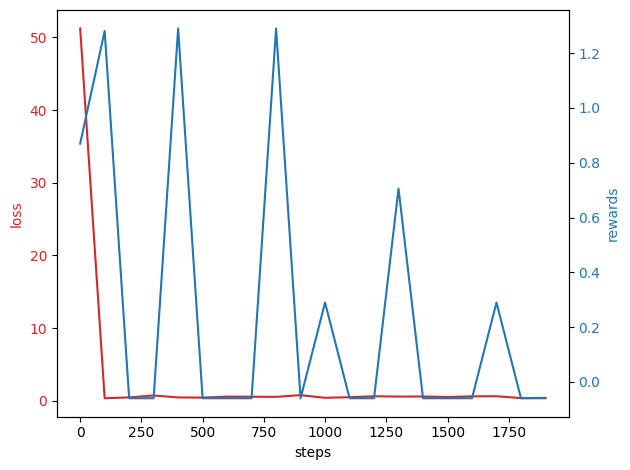

In [12]:
plot_training(loss, rewards, num_steps, 100)

### Test

In [12]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
saved_policy = tf.saved_model.load(policy_dir)

In [13]:
test_env = get_tf_env("test", env_args)
test_env_copy = get_tf_env("test", env_args)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: test (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.57],
 Env. default goal value: 0.57,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: test (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.57],
 Env. default goal value: 0.57,



In [14]:
compute_avg_return_episodic(test_env, agent.policy, num_episodes=50)

100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


-0.122350894

In [30]:
num_steps=5000
_loss_test, _, _rewards_test = train(
    agent, test_env, test_env, replay_buffer, collect_driver, steps = num_steps, eval_interval=100)

  0%|          | 3/5000 [00:06<2:29:07,  1.79s/it]

step = 0: loss = -0.08275873959064484, reward = 0.15449999272823334


  2%|▏         | 103/5000 [00:20<1:01:50,  1.32it/s]

step = 100: loss = 0.027595680207014084, reward = 0.15449999272823334


  4%|▍         | 203/5000 [00:33<1:00:14,  1.33it/s]

step = 200: loss = 0.01597478985786438, reward = 0.15449999272823334


  6%|▌         | 303/5000 [00:47<59:38,  1.31it/s]  

step = 300: loss = 0.07849355041980743, reward = 0.15449999272823334


  8%|▊         | 403/5000 [01:00<57:59,  1.32it/s]  

step = 400: loss = 0.07866153120994568, reward = 0.15449999272823334


 10%|█         | 503/5000 [01:13<56:36,  1.32it/s]  

step = 500: loss = 0.0788775384426117, reward = 0.15449999272823334


 12%|█▏        | 603/5000 [01:27<55:18,  1.33it/s]  

step = 600: loss = 0.03862088546156883, reward = 0.15449999272823334


 14%|█▍        | 703/5000 [01:40<54:29,  1.31it/s]  

step = 700: loss = 0.020812472328543663, reward = 0.15449999272823334


 16%|█▌        | 803/5000 [01:54<52:54,  1.32it/s]  

step = 800: loss = 0.030953237786889076, reward = 0.15449999272823334


 18%|█▊        | 903/5000 [02:07<51:42,  1.32it/s]  

step = 900: loss = -0.07765475660562515, reward = 0.15449999272823334


 20%|██        | 1003/5000 [02:21<53:21,  1.25it/s]  

step = 1000: loss = 0.06647924333810806, reward = 0.15449999272823334


 22%|██▏       | 1103/5000 [02:34<50:21,  1.29it/s]  

step = 1100: loss = 0.07829032093286514, reward = 0.15449999272823334


 24%|██▍       | 1203/5000 [02:48<47:26,  1.33it/s]  

step = 1200: loss = 0.07940496504306793, reward = 0.15449999272823334


 26%|██▌       | 1303/5000 [03:01<45:59,  1.34it/s]  

step = 1300: loss = 0.03141622990369797, reward = 0.15449999272823334


 28%|██▊       | 1403/5000 [03:14<44:50,  1.34it/s]  

step = 1400: loss = 0.055435724556446075, reward = 0.15449999272823334


 30%|███       | 1503/5000 [03:27<43:22,  1.34it/s]  

step = 1500: loss = 0.06776073575019836, reward = 0.15449999272823334


 32%|███▏      | 1603/5000 [03:41<42:07,  1.34it/s]

step = 1600: loss = 0.0697450116276741, reward = 0.15449999272823334


 34%|███▍      | 1703/5000 [03:54<43:14,  1.27it/s]  

step = 1700: loss = 0.0339801087975502, reward = 0.15449999272823334


 36%|███▌      | 1803/5000 [04:08<41:34,  1.28it/s]

step = 1800: loss = 0.06431885808706284, reward = 0.15449999272823334


 38%|███▊      | 1903/5000 [04:22<41:33,  1.24it/s]

step = 1900: loss = 0.0638260543346405, reward = 0.15449999272823334


 40%|████      | 2003/5000 [04:36<39:58,  1.25it/s]

step = 2000: loss = -0.06647807359695435, reward = 0.15449999272823334


 42%|████▏     | 2103/5000 [04:50<37:27,  1.29it/s]

step = 2100: loss = 0.06989308446645737, reward = 0.15449999272823334


 44%|████▍     | 2203/5000 [05:03<35:25,  1.32it/s]

step = 2200: loss = 0.07144589722156525, reward = 0.15449999272823334


 46%|████▌     | 2303/5000 [05:16<34:00,  1.32it/s]

step = 2300: loss = 0.017992911860346794, reward = 0.15449999272823334


 48%|████▊     | 2403/5000 [05:30<32:49,  1.32it/s]

step = 2400: loss = 0.06617488712072372, reward = 0.15449999272823334


 50%|█████     | 2503/5000 [05:43<31:27,  1.32it/s]

step = 2500: loss = 0.06551690399646759, reward = 0.15449999272823334


 52%|█████▏    | 2603/5000 [05:57<30:18,  1.32it/s]

step = 2600: loss = 0.06771502643823624, reward = 0.15449999272823334


 54%|█████▍    | 2703/5000 [06:10<29:36,  1.29it/s]

step = 2700: loss = 0.01253617275506258, reward = 0.15449999272823334


 56%|█████▌    | 2803/5000 [06:24<27:46,  1.32it/s]

step = 2800: loss = 0.0662756860256195, reward = 0.15449999272823334


 58%|█████▊    | 2903/5000 [06:37<26:43,  1.31it/s]

step = 2900: loss = 0.06570452451705933, reward = 0.15449999272823334


 60%|██████    | 3003/5000 [06:50<25:14,  1.32it/s]

step = 3000: loss = 0.0676717460155487, reward = 0.15449999272823334


 62%|██████▏   | 3103/5000 [07:04<23:52,  1.32it/s]

step = 3100: loss = 0.015165931545197964, reward = 0.15449999272823334


 64%|██████▍   | 3203/5000 [07:17<22:37,  1.32it/s]

step = 3200: loss = 0.06071428209543228, reward = 0.15449999272823334


 66%|██████▌   | 3303/5000 [07:31<21:27,  1.32it/s]

step = 3300: loss = 0.05883081629872322, reward = 0.15449999272823334


 68%|██████▊   | 3403/5000 [07:44<20:11,  1.32it/s]

step = 3400: loss = 0.05168354883790016, reward = 0.15449999272823334


 70%|███████   | 3503/5000 [07:57<18:50,  1.32it/s]

step = 3500: loss = 0.017617255449295044, reward = 0.15449999272823334


 72%|███████▏  | 3603/5000 [08:11<17:45,  1.31it/s]

step = 3600: loss = 0.054672833532094955, reward = 0.15449999272823334


 74%|███████▍  | 3703/5000 [08:24<16:22,  1.32it/s]

step = 3700: loss = 0.07289864867925644, reward = 0.15449999272823334


 76%|███████▌  | 3803/5000 [08:38<15:06,  1.32it/s]

step = 3800: loss = 0.06126633659005165, reward = 0.15449999272823334


 78%|███████▊  | 3903/5000 [08:51<13:51,  1.32it/s]

step = 3900: loss = 0.012533322907984257, reward = 0.15449999272823334


 80%|████████  | 4003/5000 [09:05<12:33,  1.32it/s]

step = 4000: loss = 0.0729455053806305, reward = 0.15449999272823334


 82%|████████▏ | 4103/5000 [09:18<11:23,  1.31it/s]

step = 4100: loss = 0.060445066541433334, reward = 0.15449999272823334


 84%|████████▍ | 4203/5000 [09:31<10:01,  1.33it/s]

step = 4200: loss = -0.08400257676839828, reward = 0.15449999272823334


 86%|████████▌ | 4303/5000 [09:45<08:49,  1.32it/s]

step = 4300: loss = 0.0662526786327362, reward = 0.15449999272823334


 88%|████████▊ | 4403/5000 [09:58<07:31,  1.32it/s]

step = 4400: loss = 0.0637577548623085, reward = 0.15449999272823334


 90%|█████████ | 4503/5000 [10:12<06:38,  1.25it/s]

step = 4500: loss = 0.05468904227018356, reward = 0.15449999272823334


 92%|█████████▏| 4603/5000 [10:26<05:05,  1.30it/s]

step = 4600: loss = 0.010259442031383514, reward = 0.15449999272823334


 94%|█████████▍| 4703/5000 [10:39<03:45,  1.32it/s]

step = 4700: loss = 0.008904497139155865, reward = 0.15449999272823334


 96%|█████████▌| 4803/5000 [10:52<02:29,  1.31it/s]

step = 4800: loss = -0.07732591032981873, reward = 0.15449999272823334


 98%|█████████▊| 4903/5000 [11:06<01:13,  1.31it/s]

step = 4900: loss = 0.06026251241564751, reward = 0.15449999272823334


100%|██████████| 5000/5000 [11:12<00:00,  7.43it/s]


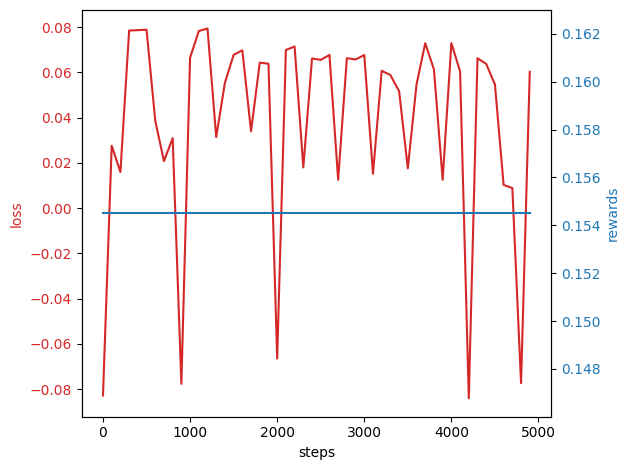

In [31]:
plot_training(_loss_test, _rewards_test, num_steps, 100)

In [ ]:
compute_avg_return_episodic(test_env, agent.policy, num_episodes=50)

Save to checkpoint.

In [ ]:
# train_checkpointer.save(global_step)

# WandB

In [9]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = True

def main():
    run = wandb.init(config = config)
    
    agent_args = {
        "q_network":            get_q_net(action_spec, fc_layer_params),
        "optimizer":            tf.compat.v1.train.AdamOptimizer(
                                    learning_rate=run.config.learning_rate),
        "n_step_update":        n_step_update, 
        "td_errors_loss_fn":    tf.keras.losses.MeanSquaredError(),
        "epsilon_greedy":       run.config.epsilon_greedy,
        "target_update_period": run.config.target_update_period,
        "gamma":                run.config.gamma,
        "gradient_clipping":    1,
        "train_step_counter":   tf.compat.v1.train.get_or_create_global_step(),
    }
        
    _agent = dqn_agent.DqnAgent(
        time_step_spec,
        action_spec,
        **agent_args
    )

    loss, _, rewards = train(_agent, train_env, train_env_copy, steps = 5000, use_wandb = True)
    
    wandb.log({'avg_loss': np.mean(loss), 'avg_reward': np.mean(rewards)})

    del _agent
    return

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'rl_greed',
    "metric": {
        "name" : "avg_reward",
        "goal": "maximize"
    },
    "parameters" : {
        "learning_rate": {
            "min": 0.0001,
            "max": 0.01
        },
        "epsilon_greedy": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
        "target_update_period": {'values': [1, 10, 100, 1000, 10000]},
        "gamma": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    ! export WANDB_NOTEBOOK_NAME="main.ipynb"
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project=PROJECT_NAME,)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: srh8mikx
Sweep URL: https://wandb.ai/cold-machines/Reinforcement%20Learning%20%28DQN%29%20-%20JVM-GC/sweeps/srh8mikx


wandb: Agent Starting Run: 86wuplng with config:
wandb: 	epsilon_greedy: 0.7
wandb: 	gamma: 0.1
wandb: 	learning_rate: 0.009081865474555018
wandb: 	target_update_period: 100
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|▏         | 101/5000 [00:16<18:44,  4.36it/s]

step = 100: loss = 0.051988594233989716, reward = -0.05968308076262474


  4%|▍         | 201/5000 [00:32<17:56,  4.46it/s]

step = 200: loss = 0.04959993064403534, reward = -0.05968308076262474


  6%|▌         | 301/5000 [00:48<17:17,  4.53it/s]

step = 300: loss = 0.05310416966676712, reward = -0.05968308076262474


  8%|▊         | 401/5000 [01:04<21:05,  3.64it/s]

step = 400: loss = 0.07190939784049988, reward = -0.05968308076262474


 10%|█         | 501/5000 [01:20<16:40,  4.50it/s]

step = 500: loss = 0.06140190362930298, reward = -0.05968308076262474


 12%|█▏        | 601/5000 [01:36<16:26,  4.46it/s]

step = 600: loss = 0.07814410328865051, reward = -0.05968308076262474


 14%|█▍        | 701/5000 [01:53<16:30,  4.34it/s]

step = 700: loss = 0.05395403504371643, reward = -0.05968308076262474


 16%|█▌        | 801/5000 [02:08<15:39,  4.47it/s]

step = 800: loss = 0.05778862535953522, reward = -0.05968308076262474


 18%|█▊        | 901/5000 [02:25<14:59,  4.56it/s]

step = 900: loss = 0.05692460760474205, reward = -0.05968308076262474


 20%|██        | 1001/5000 [02:41<15:17,  4.36it/s]

step = 1000: loss = 0.059485163539648056, reward = -0.05968308076262474


 22%|██▏       | 1101/5000 [02:57<14:36,  4.45it/s]

step = 1100: loss = 0.07164233177900314, reward = -0.05968308076262474


 24%|██▍       | 1201/5000 [03:14<14:20,  4.41it/s]

step = 1200: loss = 0.04963871091604233, reward = -0.05968308076262474


 26%|██▌       | 1301/5000 [03:30<14:23,  4.28it/s]

step = 1300: loss = 0.05595877766609192, reward = -0.05968308076262474


 28%|██▊       | 1401/5000 [03:46<13:25,  4.47it/s]

step = 1400: loss = 0.05879542976617813, reward = -0.05968308076262474


 30%|███       | 1501/5000 [04:02<12:52,  4.53it/s]

step = 1500: loss = 0.06716286391019821, reward = -0.05968308076262474


 32%|███▏      | 1601/5000 [04:18<13:14,  4.28it/s]

step = 1600: loss = 0.05800986662507057, reward = -0.05968308076262474


 34%|███▍      | 1701/5000 [04:35<12:29,  4.40it/s]

step = 1700: loss = 0.06368903815746307, reward = -0.05968308076262474


 36%|███▌      | 1801/5000 [04:51<12:38,  4.22it/s]

step = 1800: loss = 0.05840213596820831, reward = -0.05968308076262474


 38%|███▊      | 1901/5000 [05:07<11:47,  4.38it/s]

step = 1900: loss = 0.06790091097354889, reward = -0.05968308076262474


 40%|████      | 2001/5000 [05:24<11:03,  4.52it/s]

step = 2000: loss = 0.05456307530403137, reward = -0.05968308076262474


 42%|████▏     | 2101/5000 [05:39<10:43,  4.51it/s]

step = 2100: loss = 0.05199477821588516, reward = -0.05968308076262474


 44%|████▍     | 2201/5000 [05:56<10:51,  4.30it/s]

step = 2200: loss = 0.046316057443618774, reward = -0.05968308076262474


 46%|████▌     | 2301/5000 [06:12<09:51,  4.56it/s]

step = 2300: loss = 0.0451720654964447, reward = -0.05968308076262474


 48%|████▊     | 2401/5000 [06:28<09:59,  4.34it/s]

step = 2400: loss = 0.05063679814338684, reward = -0.05968308076262474


 50%|█████     | 2501/5000 [06:44<09:13,  4.51it/s]

step = 2500: loss = 0.05682305246591568, reward = -0.05968308076262474


 52%|█████▏    | 2601/5000 [07:01<08:57,  4.46it/s]

step = 2600: loss = 0.057316817343235016, reward = -0.05968308076262474


 54%|█████▍    | 2701/5000 [07:17<08:40,  4.42it/s]

step = 2700: loss = 0.06233186647295952, reward = -0.05968308076262474


 56%|█████▌    | 2801/5000 [07:34<08:08,  4.50it/s]

step = 2800: loss = 0.030263567343354225, reward = -0.05968308076262474


 58%|█████▊    | 2901/5000 [07:49<07:45,  4.51it/s]

step = 2900: loss = 0.12275780737400055, reward = -0.05968308076262474


 60%|██████    | 3001/5000 [08:06<07:35,  4.39it/s]

step = 3000: loss = 0.0640171468257904, reward = -0.05968308076262474


 62%|██████▏   | 3101/5000 [08:22<07:06,  4.45it/s]

step = 3100: loss = 0.06743437051773071, reward = -0.05968308076262474


 64%|██████▍   | 3201/5000 [08:39<07:00,  4.27it/s]

step = 3200: loss = 0.07279805094003677, reward = -0.05968308076262474


 66%|██████▌   | 3301/5000 [08:55<06:22,  4.45it/s]

step = 3300: loss = 0.03942070156335831, reward = -0.05968308076262474


 68%|██████▊   | 3401/5000 [09:12<06:25,  4.14it/s]

step = 3400: loss = 0.06413926929235458, reward = -0.05968308076262474


 70%|███████   | 3501/5000 [09:27<05:42,  4.38it/s]

step = 3500: loss = 0.04303019493818283, reward = -0.05968308076262474


 72%|███████▏  | 3601/5000 [09:43<05:13,  4.46it/s]

step = 3600: loss = 0.0326034352183342, reward = -0.05968308076262474


 74%|███████▍  | 3701/5000 [10:00<04:56,  4.38it/s]

step = 3700: loss = 0.06070145219564438, reward = -0.05968308076262474


 76%|███████▌  | 3801/5000 [10:16<04:34,  4.37it/s]

step = 3800: loss = 0.05568353831768036, reward = -0.05968308076262474


 78%|███████▊  | 3901/5000 [10:33<04:09,  4.40it/s]

step = 3900: loss = 0.0671439915895462, reward = -0.05968308076262474


 80%|████████  | 4001/5000 [10:49<03:42,  4.49it/s]

step = 4000: loss = 0.07973361760377884, reward = -0.05968308076262474


 82%|████████▏ | 4101/5000 [11:06<03:38,  4.11it/s]

step = 4100: loss = 0.05744113028049469, reward = -0.05968308076262474


 84%|████████▍ | 4201/5000 [11:22<03:00,  4.44it/s]

step = 4200: loss = 0.04437218979001045, reward = -0.05968308076262474


 86%|████████▌ | 4301/5000 [11:37<02:34,  4.51it/s]

step = 4300: loss = 0.06655722111463547, reward = -0.05968308076262474


 88%|████████▊ | 4401/5000 [11:55<02:13,  4.49it/s]

step = 4400: loss = 0.054657574743032455, reward = -0.05968308076262474


 90%|█████████ | 4501/5000 [12:10<01:51,  4.49it/s]

step = 4500: loss = 0.05559392273426056, reward = -0.05968308076262474


 92%|█████████▏| 4601/5000 [12:27<01:32,  4.31it/s]

step = 4600: loss = 0.062225304543972015, reward = -0.05968308076262474


 94%|█████████▎| 4678/5000 [12:39<00:49,  6.51it/s]

### Restore checkpoint

In [ ]:
def test(policy, test_env, num_episodes: int=10000):
    rewards = []
    log_interval = 100
    time_step = test_env.reset()
    total_return = 0.0
    for i in tqdm(range(10000)):
        policy_state = policy.action(time_step)
        time_step = test_env.step(policy_state.action)
        reward = time_step.reward.numpy()[0]
        total_return += reward # Calculate a sum of rewards

        if i % log_interval == 0:
            # avg_return = compute_avg_return(train_env_copy, agent.policy, 10)
            avg_return = total_return / eval_interval
            print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
            rewards.append(avg_return)
            total_return = 0.0 # reset
    return rewards

# test(agent.policy, test_env)

# Episodic Memory

In [70]:
from util import episodic_memory
from sklearn.mixture import GaussianMixture

def embedding_similarity(x1, x2):
    assert x1.shape[0] == x2.shape[0]
    epsilon = 1e-6

    # Inner product between the embeddings in x1
    # and the embeddings in x2.
    s = np.sum(x1 * x2, axis=-1)

    s = s / (np.linalg.norm(x1, axis=-1) * np.linalg.norm(x2, axis=-1) + epsilon)
    return 0.5 * (s + 1.0)


In [66]:
observations = replay_buffer.gather_all()[1].numpy().squeeze()
actions = replay_buffer.gather_all()[2].numpy().squeeze()
size = 15

memory_buffer = np.array([[*observations[i], actions[i]] for i in range(size)])

In [82]:
memory_buffer.squeeze().shape

(15, 3)

In [76]:
gm = GaussianMixture(n_components=memory_buffer.shape[1])

In [77]:
gm.fit(memory_buffer)

GaussianMixture(n_components=3)

In [84]:
gm.predict_proba([[7, 12, 0]])

array([[0.00000000e+00, 9.99999917e-01, 8.31505676e-08]])

In [62]:
df = pd.read_csv(f"avrora_synthetic_saved_states.csv")
print("df size:", len(df))
states  = {}
size = 15 
# replay_buffer.capacity
for i in range(size):
    states [i] = {"args": [df["MaxTenuringThreshold"].values[i], df["ParallelGCThreads"].values[i]], "goal": df["Average GC Pause"].values[i]}

# memory_buffer = np.array([states[i]["args"] for i in states.keys()])
memory_buffer = np.array([[*observations[i], actions[i]] for i in range(size)])
print(memory_buffer)

df size: 36
[[ 4 24  3]
 [ 4 24  1]
 [ 7 24  2]
 [ 7 20  2]
 [ 7 16  3]
 [ 7 20  0]
 [ 4 20  3]
 [ 4 24  2]
 [ 4 20  2]
 [ 4 16  2]
 [ 4 12  1]
 [ 7 12  0]
 [ 4 12  1]
 [ 7 12  3]
 [ 7 16  2]]


In [92]:
perf_states = {}
perf_states[0] = {"args": [7, 12], "goal": 0.47, "count": 1} 
saved_states = [perf_states[i]["args"] for i in perf_states.keys()]
flags = [7, 12]
if flags in saved_states:
    for i in perf_states.keys():
        """ 
        If current state is stored in a cache,
        update the state goal value.
        """
        if flags == perf_states[i]["args"]:
            goal = perf_states[i]["goal"]
            perf_states[i]["count"] += 1

print(perf_states)

{0: {'args': [7, 12], 'goal': 0.47, 'count': 2}}


In [97]:
for i in perf_states.keys():
    if [7, 12] == perf_states[i]["args"]:
        print(perf_states[i]["count"])

2


In [15]:
(1 + 0.01)**(-1/4)

0.9975155087566253

In [63]:
observation = np.array([[7, 12, 3]] * size)
similarity = embedding_similarity(observation, memory_buffer[:size])
similarity

array([0.96638056, 0.96084794, 0.98113075, 0.98760397, 0.99632883,
       0.97980966, 0.97269349, 0.9640097 , 0.97034901, 0.97857303,
       0.98519848, 0.98873447, 0.98519848, 1.        , 0.99432438])

In [48]:
traj

Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[ 7, 12]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [47]:
import math

math.log(0.00001)

-11.512925464970229

In [7]:
observations = replay_buffer.gather_all()[1].numpy().squeeze()
print(len(observations))
# for i in range(100):
#     print(f"[{i}] {observations[i]}")

print(f"[{0}] {observations[0]}")
print(f"[{10}] {observations[10]}")
print(f"[{15}] {observations[15]}")
print(f"[{2}] {observations[2]}")
print(f"[{4}] {observations[4]}")

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


10000
[0] [ 7 12]
[10] [ 7 16]
[15] [4 8]
[2] [10  8]
[4] [ 4 12]


In [10]:
observation_shape = [2]
memory = episodic_memory.EpisodicMemory(
    observation_shape=observation_shape,
    observation_compare_fn=embedding_similarity,
    capacity=150)

memory.add(observation=observations[0], info=dict())
memory.add(observation=observations[10], info=dict())
memory.add(observation=observations[15], info=dict())
memory.add(observation=observations[2], info=dict())
memory.add(observation=observations[4], info=dict())

In [35]:
similarities = memory.similarity(observations[0])
print(similarities)

[1.         0.99556546 0.99941687 1.         1.        ]


0.4711529108389231

In [56]:
new_df = pd.read_csv(f"avrora_synthetic_saved_states.csv")
perf_states  = {}
flags = [7, 12]
def synthethic_run(flags):
    assert len(flags) == 2, "Amount of flags is not 2"
    row = new_df[((new_df["MaxTenuringThreshold"] == flags[0]) & (new_df["ParallelGCThreads"] == flags[1]))].values.squeeze()
    goal = row[2]
    return goal

synthethic_run(flags)

0.4711529108389231